In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import plotly, pickle
import plotly.plotly as py
import plotly.graph_objs as go
from shapely import geometry
import seaborn as sns

def rand_jitter(arr, intensity = .01):
    stdev = intensity*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

In [2]:
noise_ft = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/out/noise-merge.csv')
noise_ft = noise_ft.drop('Unnamed: 0', axis = 1)
len(noise_ft)

1911

In [3]:
noise_obs = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/merge-aws/coord-in/noise-merged.csv')
noise_obs = noise_obs.drop('Unnamed: 0', axis = 1)
len(noise_obs)

1911

In [4]:
noise = pd.concat([noise_obs,
                   noise_ft.drop(['lat', 'lng'], axis = 1)],
                  axis = 1)
len(noise)

1911

In [5]:
noise_grpd = noise
noise_grpd = noise_grpd.assign(
    lat_rnd = lambda x: np.round(x.lat, decimals = 3),
    lng_rnd = lambda x: np.round(x.lng, decimals = 3)
)

noise_grpd['group'] = noise_grpd.apply(lambda x:'%s_%s' % (x['lat_rnd'], x['lng_rnd']), axis=1)
noise_grpd['group'] = pd.Series(noise_grpd['group'], dtype = 'category')
noise_grpd['group'] = noise_grpd.group.cat.codes

noise_grpd.group.nunique()

609

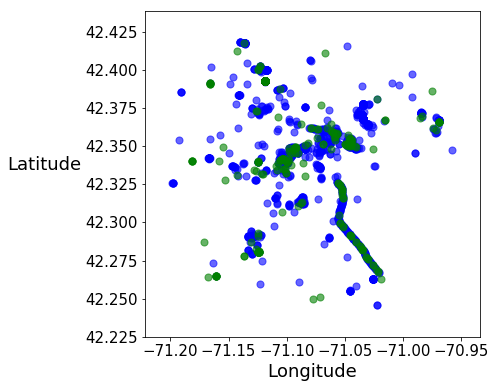

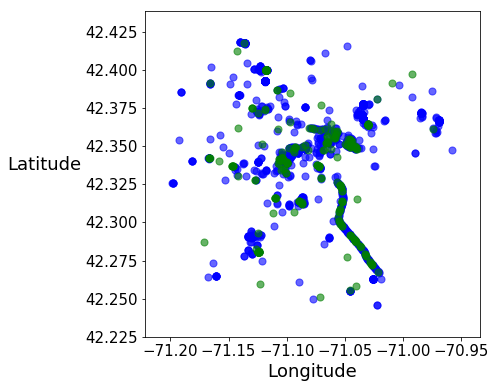

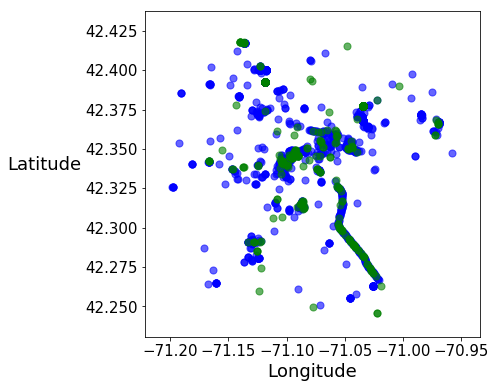

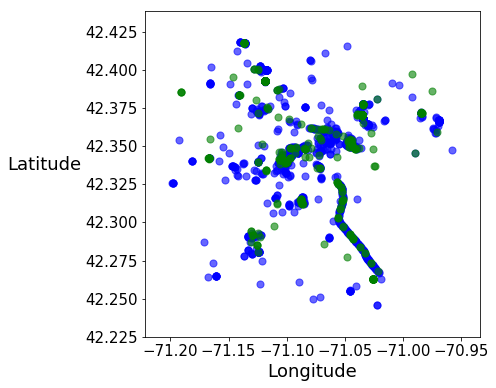

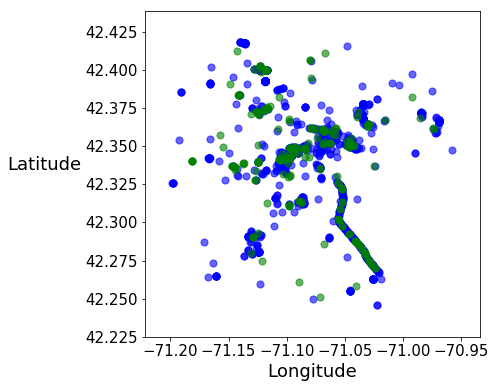

In [180]:
# visualize blocked CV split
X = noise_grpd.drop([
    'group',
    'lat_rnd',
    'lng_rnd',
    'db', 
    'minute',
    'n_agg',
    'dur',
    'hour',
    'day',
    'wkday',
    'hr_bkt'
    ], axis = 1)
y = noise_grpd['db']
groups = noise_grpd['group']

gss = GroupShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

for train, test in gss.split(X, y, groups = groups):
    # this indexing method is recommended in docs here:
    # http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-deprecate-loc-reindex-listlike
    trn_idx, tst_idx = X.index.intersection(train), X.index.intersection(test)
    
    plt.figure(figsize = (6, 6))
    plt.scatter(X.lng[trn_idx], X.lat[trn_idx], s = 50, c = 'blue', alpha = 0.6)
    plt.scatter(X.lng[tst_idx], X.lat[tst_idx], s = 50, c = 'green', alpha = 0.6)
    plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18, rotation = 0, ha='right')
    plt.tick_params(axis="x", labelsize = 15)
    plt.tick_params(axis="y", labelsize = 15)

In [191]:
mapbox_access_token = 'pk.eyJ1IjoiYmVuc2h1bG1hbiIsImEiOiJjand2ZnUxYmUwN3JkNDlsZmE1ajFiMXI0In0.y4SeH8uf0OUZzDmssIa3Fw'
plotly.tools.set_credentials_file(username='benshulman', api_key='n3APnw9QVFL8Rljv02qk')

gss = GroupShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)

# returns two arrays
# wrapped in list, else returns generator
train_idx, test_idx = list(gss.split(X, y, groups = groups))[4]


# this indexing method is recommended in docs here:
# http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#indexing-deprecate-loc-reindex-listlike
train_idx, test_idx = X.index.intersection(train_idx), X.index.intersection(test_idx)
    
data = [
    go.Scattermapbox(
        name = 'Train',
        lat = X.lat[train_idx],
        lon = X.lng[train_idx],
        mode='markers',
        hoverinfo = 'text',
        text = pred_grid.db.round(decimals = 0),
        marker = go.scattermapbox.Marker(
            size = 15,
            color = 'blue'
        )
    ),
    
    go.Scattermapbox(
        name='Test',
        lat = X.lat[test_idx],
        lon = X.lng[test_idx],
        mode='markers',
        hoverinfo = 'text',
        text = pred_grid.db.round(decimals = 0),
        marker = go.scattermapbox.Marker(
            size = 15,
            color = 'green'
        )
    ),
]

layout = go.Layout(
    width = 800,
    height = 800,
    autosize=True,
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat = 42.3665,
            lon = -71.079
        ),
        pitch = 0,
        zoom = 12.5
    ),
 legend=dict(
        traceorder='normal',
        font=dict(
            family='sans-serif',
            size=18
        )
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='noise-block-cv')

In [ ]:
def rfrst_nest_test(n_est_vals, X, y, groups):
    '''
    test the performance with different n_estimators
    :param data: train_data, test_data, train_value, test_value
    :return: data frame with n_estimators and performance
    '''
    gss = GroupShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    # wrap in list because need indices not generator; else error
    # per https://github.com/rasbt/mlxtend/issues/373#issuecomment-384151474
    cv = list(gss.split(X, y, groups))
    cv_scores = list()
    cv_sd = list()
    for n_est in n_est_vals:
        params = {
            'n_estimators': n_est,
            'min_samples_split': 2
        }
        rfrst = RandomForestRegressor(**params)
        scores = cross_val_score(rfrst, X, y, groups, 'r2', cv, n_jobs = -1)
        cv_scores.append(scores.mean())
        cv_sd.append(scores.std())
    df_out = pd.DataFrame({
        'n_estimators': n_est_vals,
        'cv_r2': cv_scores,
        'cv_r2_sd': cv_sd
    })
    return df_out

n_est_vals = np.concatenate([
    np.arange(1, 10, step = 3),
    np.arange(10, 200, step = 20),
    np.arange(200, 501, step = 50)
])

nest_cv = rfrst_nest_test(n_est_vals, X, y, groups)

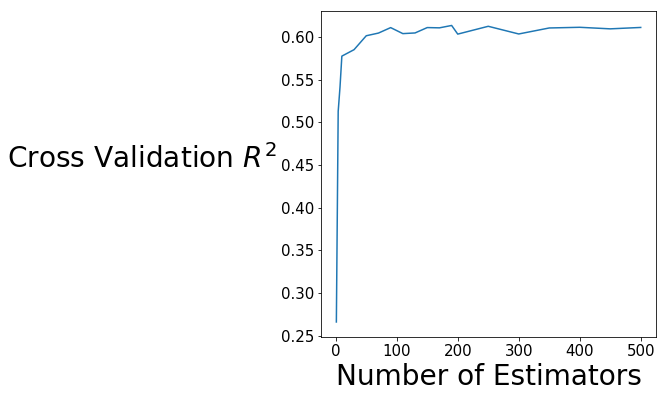

In [371]:
plt.figure(figsize = (6, 6))
plt.plot(nest_cv.n_estimators, nest_cv.cv_r2)
plt.xlabel("Number of Estimators", fontsize=28)
plt.ylabel(r"Cross Validation $R^2$", fontsize=28, rotation=0, ha='right')
plt.tick_params(axis="x", labelsize = 15)
plt.tick_params(axis="y", labelsize = 15)
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/r2-cv-m5.png', dpi=300, bbox_inches='tight')

In [372]:
nest_cv

,n_estimators,cv_r2
0,1,0.266229
1,4,0.512759
2,7,0.541497
3,10,0.577448
4,30,0.584999
5,50,0.601291
6,70,0.604429
7,90,0.610827
8,110,0.603797
9,130,0.604573


In [7]:
# CV scoring
X = noise_grpd.drop([
    'group',
    'lat_rnd',
    'lng_rnd',
    'lat',
    'lng',
    'db', 
    'minute',
    'n_agg',
    'dur',
    'hour',
    'day',
    'wkday',
    'hr_bkt'
    ], axis = 1)
y = noise_grpd['db']
groups = noise_grpd['group']

gss = GroupShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
cv = gss.split(X, y, groups)

params = {
    'n_estimators': 500,
    'min_samples_split': 2
}

rfrst = RandomForestRegressor(**params)

scores = cross_val_score(rfrst, X, y, groups, 'r2', cv, n_jobs = -1)

In [264]:
scores.mean() # nestimators = 500, decimals = 3, groups within 100 m of each other

0.611068329661659

In [8]:
# final model
params = {
    'n_estimators': 500,
    'min_samples_split': 2
}

rfrst = RandomForestRegressor(**params)

rfrst.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=500,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [53]:
# pickle the model
with open('/Users/Ben/Dropbox/Insight/modeling/model-5-rfrst.pkl', 'wb') as f:
    pickle.dump(rfrst, f)
# save out X_train columns to use in predictions script
with open('/Users/Ben/Dropbox/Insight/modeling/model-5-x-cols.pkl', 'wb') as f:
    pickle.dump(X.columns, f)

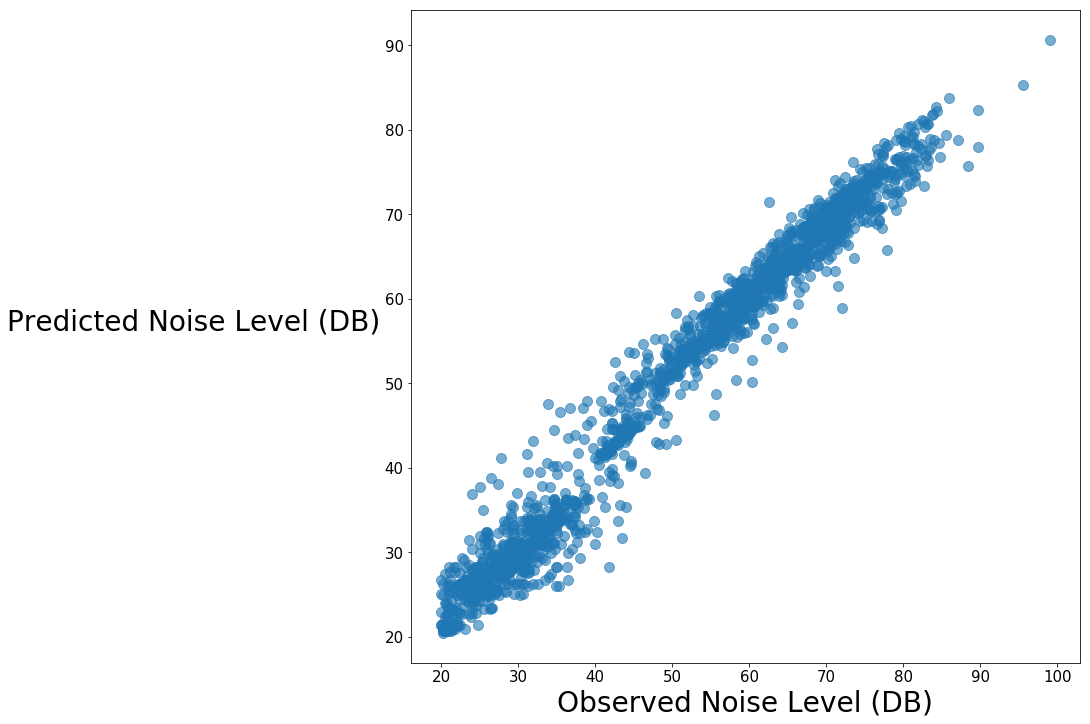

In [10]:
plt.figure(figsize = (12, 12))
plt.scatter(y, rfrst.predict(X), s = 100, alpha = 0.6)
plt.xlabel('Observed Noise Level (DB)', fontsize=28); plt.ylabel('Predicted Noise Level (DB)', fontsize=28, rotation=0, ha='right')
plt.tick_params(axis="x", labelsize = 15)
plt.tick_params(axis="y", labelsize = 15)
# plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, rfrst.predict(X_test), 1))(np.unique(y_test)))
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/pred-obs-fit-5.png', dpi=300, bbox_inches='tight')

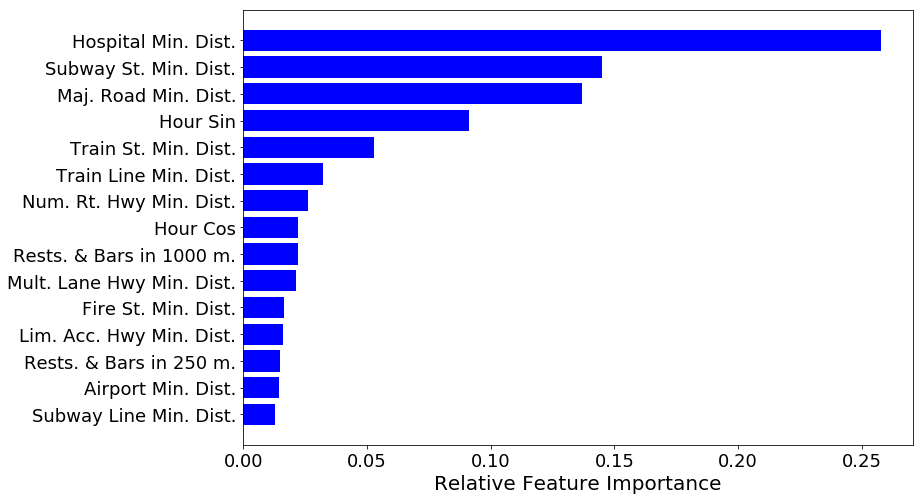

In [78]:
importances = list(rfrst.feature_importances_)
features = list(X.columns.values)

ft_imp = pd.DataFrame({
    'features': features,
    'importances': importances
})

ft_imp = ft_imp.sort_values(by = 'importances', ascending = False).reset_index(drop = True)

ft_imp = ft_imp[0:15]

ft_imp['features'] = [
    'Hospital Min. Dist.',
    'Subway St. Min. Dist.',
    'Maj. Road Min. Dist.',
    'Hour Sin',
    'Train St. Min. Dist.',
    'Train Line Min. Dist.',
    'Num. Rt. Hwy Min. Dist.',
    'Hour Cos',
    'Rests. & Bars in 1000 m.',
    'Mult. Lane Hwy Min. Dist.',
    'Fire St. Min. Dist.',
    'Lim. Acc. Hwy Min. Dist.',
    'Rests. & Bars in 250 m.',
    'Airport Min. Dist.',
    'Subway Line Min. Dist.'
]

plt.figure(figsize = (12., 8))
plt.barh(range(len(ft_imp)), ft_imp.importances, color='b', align='center')
plt.yticks(range(len(ft_imp)), ft_imp.features, fontsize = 18)
plt.xticks(fontsize = 18)
plt.xlabel('Relative Feature Importance', fontsize = 20)
plt.gca().invert_yaxis()
# plt.show()
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/feat-imp-5.png', dpi=300, bbox_inches='tight')

In [55]:
# in make_grid.py I make a grid of points across the map and compute feature distances for each point
pred_grid = pd.read_csv('/Users/Ben/Dropbox/Insight/data-merge/pred_grid_crop.csv')
pred_grid = pred_grid.drop('Unnamed: 0', axis = 1)

len(pred_grid)

34382

In [58]:
pred_grid['hour'] = 13
pred_grid['day'] = 0

# cyclic encoding of hour
pred_grid['hour_sin'] = np.sin(2 * np.pi * pred_grid['hour'] / 23)
pred_grid['hour_cos'] = np.cos(2 * np.pi * pred_grid['hour'] / 23)
# cyclic encoding of day
pred_grid['day_sin'] = np.sin(2 * np.pi * pred_grid['day'] / 6)
pred_grid['day_cos'] = np.cos(2 * np.pi * pred_grid['day'] / 6)

# request model predictions for each point
pred_grid['db'] = rfrst.predict(pred_grid[X.columns])

Text(0, 0.5, 'Latitude')

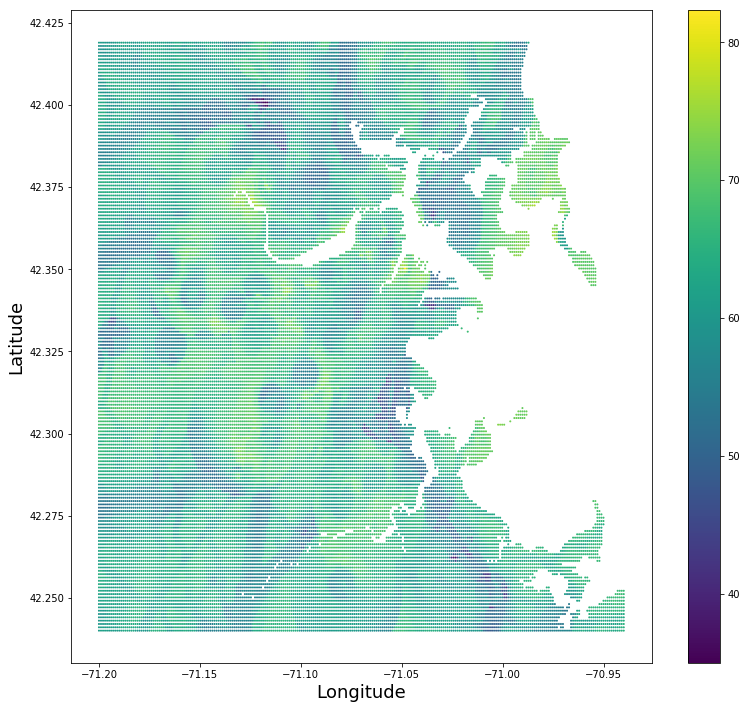

In [62]:
plt.figure(figsize = (13, 12))
plt.scatter(pred_grid.lng, pred_grid.lat, s = 1, c = pred_grid.db)
plt.colorbar(); plt.xlabel('Longitude', fontsize=18); plt.ylabel('Latitude', fontsize=18)

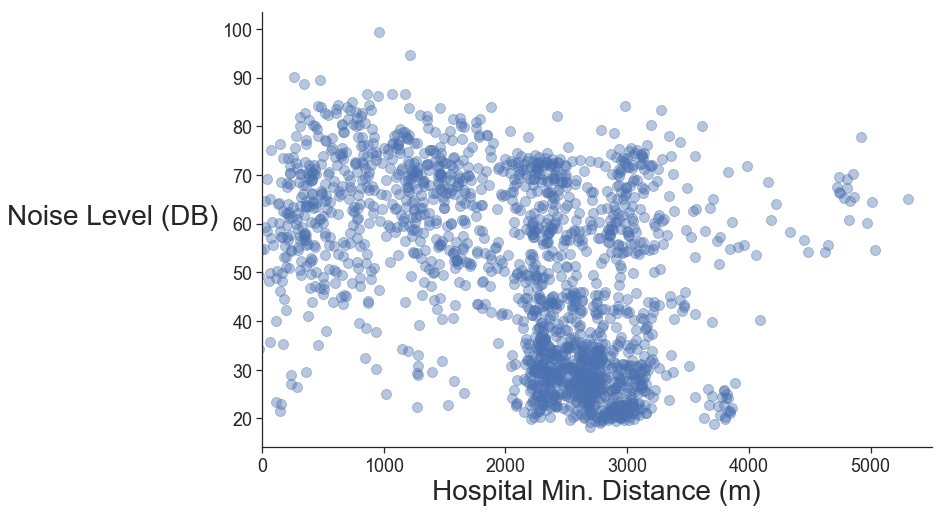

In [251]:
plt.figure(figsize = (12, 8))
sns.set_style("ticks")
plt.scatter(rand_jitter(noise.hosp_min_dist, .013), rand_jitter(noise.db, .013), s = 100, alpha = 0.4)
plt.xlabel('Hospital Min. Distance (m)', fontsize=28); plt.ylabel('Noise Level (DB)', fontsize=28, rotation=0, ha='right')
plt.xlim([0, 5500])
plt.tick_params(axis="x", labelsize = 18)
plt.tick_params(axis="y", labelsize = 18)
sns.despine()
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/hosp-dist-eda.png', dpi=300, bbox_inches='tight')

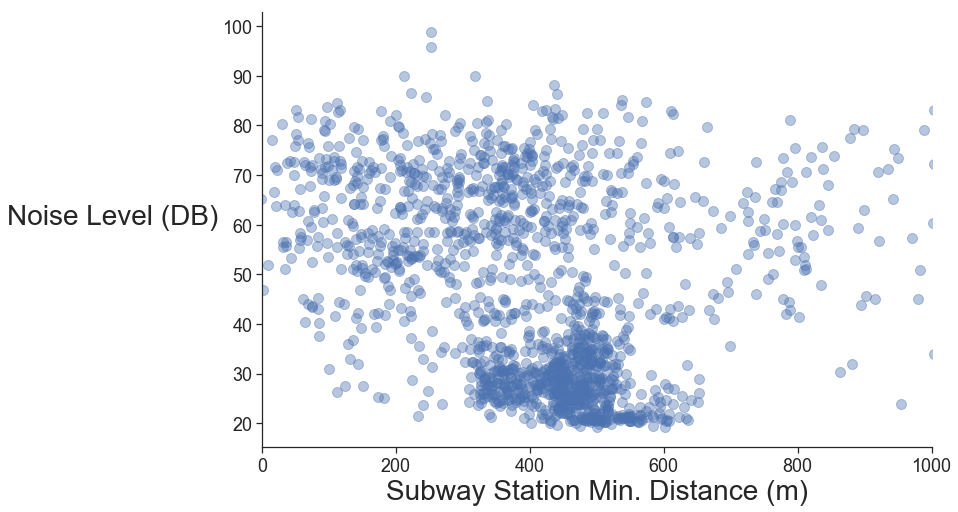

In [248]:
plt.figure(figsize=(12,8))
sns.set_style("ticks")
plt.scatter(rand_jitter(noise.sbwy_st_min_dist, .005), rand_jitter(noise.db, .005), s = 100, alpha = 0.4)
plt.xlabel('Subway Station Min. Distance (m)', fontsize=28); plt.ylabel('Noise Level (DB)', fontsize=28, rotation=0, ha='right')
plt.xlim([0, 1000])
plt.tick_params(axis="x", labelsize = 18)
plt.tick_params(axis="y", labelsize = 18)
sns.despine()
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/sbwy-dist-eda.png', dpi=300, bbox_inches='tight')

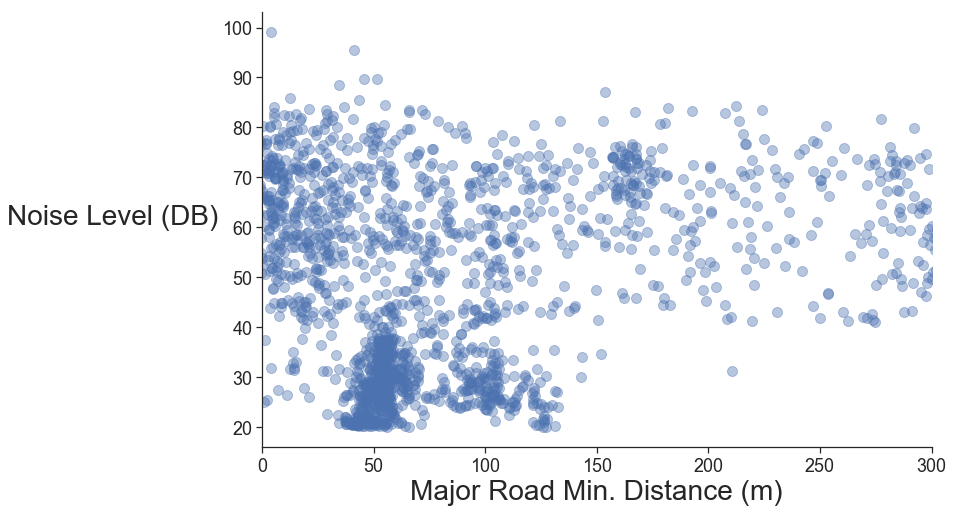

In [250]:
plt.figure(figsize = (12, 8))
sns.set_style("ticks")
plt.scatter(rand_jitter(noise.maj_rd_min_dist, .001), rand_jitter(noise.db, .001), s = 100, alpha = 0.4)
plt.xlabel('Major Road Min. Distance (m)', fontsize=28); plt.ylabel('Noise Level (DB)', fontsize=28, rotation=0, ha='right')
plt.xlim([0, 300])
plt.tick_params(axis="x", labelsize = 18)
plt.tick_params(axis="y", labelsize = 18)
sns.despine()
plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/majrd-dist-eda.png', dpi=300, bbox_inches='tight')

<Figure size 5760x5760 with 0 Axes>

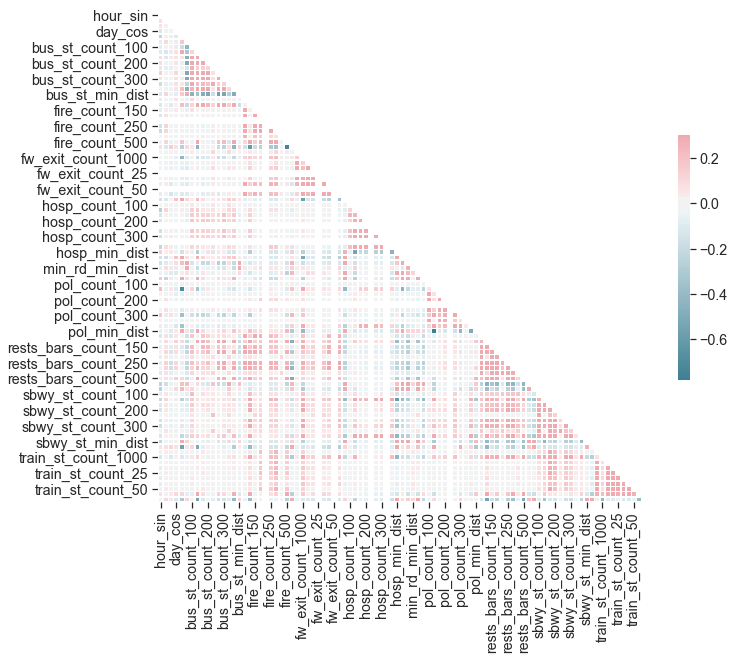

In [266]:
plt.figure(figsize = (80, 80))

corr = X.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.savefig('/Users/Ben/Dropbox/Insight/slide-figures/corr-mat.png', dpi=300, bbox_inches='tight')